In [1]:
from os.path import join

import csiborgtools
import matplotlib.pyplot as plt
import numpy
import scienceplots  # noqa
from cache_to_disk import cache_to_disk, delete_disk_caches_for_function  # noqa

import plt_utils

%load_ext autoreload
%autoreload 2

# Field evaluated at radial shells

In [198]:
# TODO: This is a little dodgy

def plot_field_shells(field, MAS, grid, to_save=True):
    folder = "/mnt/extraspace/rstiskalek/csiborg_postprocessing/field_shells"

    # with plt.style.context("notebook"):
    if True:
        cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
        lw = plt.rcParams['lines.linewidth']
        plt.figure()

        # CSiBORG2 main
        fname = join(folder, f"csiborg2_main_{field}_{MAS}_{grid}.npz")
        file = numpy.load(fname)
        dist, mean = file["distances"], file["mean"]
        mean /= dist
        mean /= 70
        for i in range(len(mean)):
            plt.plot(dist, mean[i], c=cols[0], label="CSiBORG" if i == 0 else None)
        
        # # BORG2
        # fname = join(folder, f"borg2_{field}_{MAS}_{grid}.npz")
        # file = numpy.load(fname)
        # dist, mean = file["distances"], file["mean"]
        # for i in range(len(mean)):
        #     plt.plot(dist, mean[i], c=cols[2], label="BORG" if i == 0 else None)

        # # CSiBORG2 random
        # fname = join(folder, f"csiborg2_random_{field}_{MAS}_{grid}.npz")
        # file = numpy.load(fname)
        # dist, mean = file["distances"], file["mean"]

        # mu = numpy.mean(mean, axis=0)
        # std = numpy.std(mean, axis=0)

        # plt.fill_between(dist, mu - std, mu + std, alpha=1/3, color=cols[1])

        # for i in range(len(mean)):
            # plt.plot(dist, mean[i], c=cols[1], label="Random" if i == 0 else None, zorder=0, lw=lw/2)

        # Plot settings
        plt.legend(loc="lower right")
        plt.xlabel(r"$r ~ [\mathrm{Mpc} / h]$")

        if field == "radvel":
            plt.ylabel(r"$\langle v_r \rangle ~ [\mathrm{km} / s]$")
            plt.axhline(0, c="k", ls="--",)
            plt.ylim(-0.1, 0.1)
            plt.xscale("log")
        elif field == "overdensity":
            plt.ylim(-0.5, 0.5)
            plt.axhline(0, c="k", ls="--",)
            # plt.xlim(0, 200)
            plt.ylabel(r"$\langle \delta_r \rangle$")
            # plt.axhline(-0.1, c="k", ls="--")
        elif field == "density":
            plt.axhline(277.5 * 0.304, c="k", ls="--",)
            plt.ylim(50, 100)

        plt.xlim(0, dist.max())
        # plt.xlim(0, 100)

        if to_save:
            fout = join(plt_utils.fout, f"field_shells_{field}_{MAS}_{grid}.png")
            print(f"Saving to `{fout}`.")
            plt.savefig(fout, dpi=plt_utils.dpi, bbox_inches="tight")

        plt.show()

/tmp/ipykernel_16251/4241837727.py:58: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, dist.max())


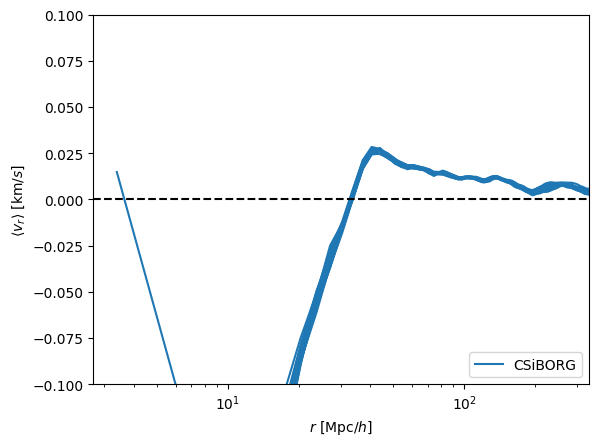

In [199]:
plot_field_shells("radvel", "SPH", 1024, False)

## Enclosed mass 

In [145]:
def plot_enclosed_overdensity(to_save=True):
    with plt.style.context("science"):
    # if True:
        plt.figure()

        # CSiBORG2 main
        d = numpy.load("/mnt/extraspace/rstiskalek/csiborg_postprocessing/field_shells/enclosed_mass_csiborg2_main.npz")
        V = 4 / 3 * numpy.pi * d["distances"]**3
        V35 = 4 / 3 * numpy.pi * 135**3
        rho_mean = 0.3111 * 277.54
        boxsize = csiborgtools.simname2boxsize("csiborg2_main")

        dist = d["distances"]
        density = d["enclosed_mass"] / V * 1e-9 / rho_mean - 1

        density135 = d["mass135"] / V35 * 1e-9 / rho_mean - 1
        densitytot = d["masstot"] / boxsize**3 * 1e-9 / rho_mean - 1

        print(f"CSiBORG2_main overdensity within 135 Mpc / h: {numpy.mean(density135)} +- {numpy.std(density135)}")
        print(f"CSiBORG2_main density of the entire box:      {numpy.mean(densitytot)} +- {numpy.std(densitytot)}")
        for i in range(len(density)):
            plt.plot(dist, density[i], c="C0", alpha=0.25, ls="dashed")
        plt.plot(dist, numpy.mean(density, axis=0), c="C0", label="CSiBORG2")


        plt.ylim(-0.125, 0.025)
        plt.axvline(135, c="k", ls="--")
        plt.xlabel(r"$r ~ [\mathrm{Mpc} / h]$")
        plt.ylabel(r"$\langle \delta_r \rangle$")
        plt.legend()

        if to_save:
            fout = join(plt_utils.fout, f"enclosed_overdensity.png")
            print(f"Saving to `{fout}`.")
            plt.savefig(fout, dpi=plt_utils.dpi, bbox_inches="tight")

        plt.show()

CSiBORG2_main overdensity within 135 Mpc / h: -0.04873031959704639 +- 0.002019823388775199
CSiBORG2_main density of the entire box:      -7.126655948078153e-05 +- 2.4011490016727015e-07
Saving to `../plots/enclosed_overdensity.png`.


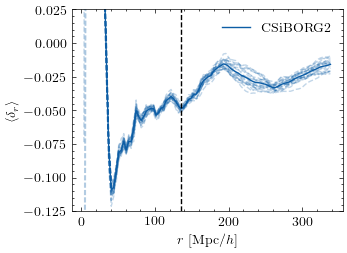

In [148]:
plot_enclosed_overdensity(True)

## Bulk flow

In [182]:
def process_bulkflow_amplitude(cumulative_velocity, subtract_observer):
    if isinstance(subtract_observer, bool):
        if subtract_observer:
            subtract_observer = 0
        else:
            return numpy.linalg.norm(cumulative_velocity, axis=-1)

    if not isinstance(subtract_observer, int):
        raise TypeError("Incorrect type for `subtract_observer`.")

    for i in range(len(cumulative_velocity)):
        for j in range(3):
            cumulative_velocity[i, :, j] -= cumulative_velocity[i, subtract_observer, j]

    return numpy.linalg.norm(cumulative_velocity, axis=-1)


def plot_bulkflow_amplitude(subtract_observer=False, to_save=True):
    with plt.style.context("science"):
    # if True:
        plt.figure()

        # CSiBORG2 main
        d = numpy.load("/mnt/extraspace/rstiskalek/csiborg_postprocessing/field_shells/enclosed_mass_csiborg2_main.npz")
        dist = d["distances"]
        cumulative_velocity = d["cumulative_velocity"]
        cumulative_velocity_amplitude = process_bulkflow_amplitude(cumulative_velocity, subtract_observer)

        for i in range(len(cumulative_velocity_amplitude)):
            plt.plot(dist, cumulative_velocity_amplitude[i], c="C0", alpha=0.25, ls="dashed")
        plt.plot(dist, numpy.mean(cumulative_velocity_amplitude, axis=0), c="C0", label="CSiBORG2")


        plt.axvline(135, c="k", ls="--")
        plt.xlabel(r"$r ~ [\mathrm{Mpc} / h]$")
        plt.ylabel(r"$\langle U \rangle ~ [\mathrm{km} / \mathrm{s}]$")
        plt.legend()

        if to_save:
            fout = join(plt_utils.fout, f"enclosed_overdensity.png")
            print(f"Saving to `{fout}`.")
            plt.savefig(fout, dpi=plt_utils.dpi, bbox_inches="tight")

        plt.show()

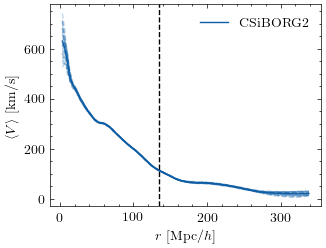

In [183]:
plot_bulkflow_amplitude(False, False)